In [154]:
# Machine learning libraries
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Data manipulation
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# yahoo finance is used to fetch data
import yfinance as yf

#date and time
import datetime as dt
current_date = dt.datetime.now()

[*********************100%***********************]  1 of 1 completed


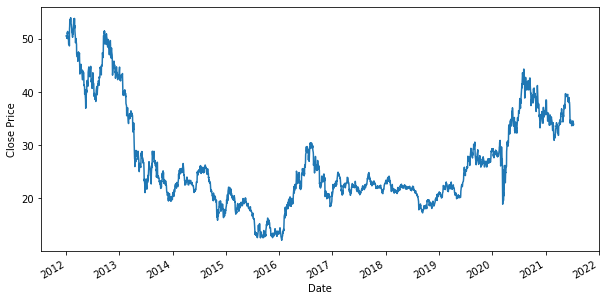

In [155]:
# Read the data
Df = yf.download('GDX', '2012-01-01', current_date, auto_adjust=True)
#Df = Df[['Close']]

# Plot the closing price of GLD
Df.Close.plot(figsize=(10, 5))
plt.ylabel("Close Price")
plt.show()

In [156]:
# Calculate 3-day moving average of close prices
Df['S_3'] = Df['Close'].shift(1).rolling(window=3).mean()

# Calculate 15-day moving average of close prices
Df['S_15'] = Df['Close'].shift(1).rolling(window=15).mean()

# Calculate 60-day moving average of close prices
Df['S_60'] = Df['Close'].shift(1).rolling(window=60).mean()

# Calculate the correlation between close price and 3 day moving average
Df['Corr'] = Df['Close'].shift(1).rolling(window=10).corr(Df['S_3'].shift(1))

Df['Std_U'] = Df['High']-Df['Open']
Df['Std_D'] = Df['Open']-Df['Low']

Df['OD'] = Df['Open']-Df['Open'].shift(1)
Df['OL'] = Df['Open']-Df['Close'].shift(1)

Df.tail()

,Open,High,Low,Close,Volume,S_3,S_15,S_60,Corr,Std_U,Std_D,OD,OL
Date,,,,,,,,,,,,,
2021-07-06,35.020000,35.049999,34.169998,34.520000,19947100,34.119999,34.925333,36.659333,0.635214,0.029999,0.850002,0.630001,0.600002
2021-07-07,34.740002,34.790001,34.290001,34.560001,14493700,34.299999,34.691333,36.655833,0.318429,0.049999,0.450001,-0.279999,0.220001
2021-07-08,34.619999,34.689999,33.389999,33.680000,27118300,34.500000,34.489333,36.665833,0.205327,0.070000,1.230000,-0.120003,0.059998
2021-07-09,33.799999,34.490002,33.759998,34.369999,18200000,34.253334,34.283333,36.651167,-0.041213,0.690002,0.040001,-0.820000,0.119999
2021-07-12,34.200001,34.560001,33.830002,33.889999,20288500,34.203334,34.246000,36.652500,-0.173201,0.360001,0.369999,0.400002,-0.169998


In [157]:
X = Df[['Open', 'S_3', 'S_15', 'S_60', 'OD', 'OL', 'Corr']]
X.tail()

,Open,S_3,S_15,S_60,OD,OL,Corr
Date,,,,,,,
2021-07-06,35.020000,34.119999,34.925333,36.659333,0.630001,0.600002,0.635214
2021-07-07,34.740002,34.299999,34.691333,36.655833,-0.279999,0.220001,0.318429
2021-07-08,34.619999,34.500000,34.489333,36.665833,-0.120003,0.059998,0.205327
2021-07-09,33.799999,34.253334,34.283333,36.651167,-0.820000,0.119999,-0.041213
2021-07-12,34.200001,34.203334,34.246000,36.652500,0.400002,-0.169998,-0.173201


In [158]:
yU = Df['Std_U']
yU.tail()

Date
2021-07-06    0.029999
2021-07-07    0.049999
2021-07-08    0.070000
2021-07-09    0.690002
2021-07-12    0.360001
Name: Std_U, dtype: float64

In [159]:
yD = Df['Std_D']
yD.tail()

Date
2021-07-06    0.850002
2021-07-07    0.450001
2021-07-08    1.230000
2021-07-09    0.040001
2021-07-12    0.369999
Name: Std_D, dtype: float64

In [160]:
imp = SimpleImputer(missing_values = np.nan, strategy='most_frequent')
steps = [('imputation', imp),
         ('scaler',StandardScaler()),
         ('linear',LinearRegression())]     
pipeline = Pipeline(steps)

In [161]:
parameters = {'linear__fit_intercept':[0,1]}

In [162]:
reg = GridSearchCV(pipeline, parameters, cv=5)

In [163]:
t = .8
split = int(t*len(Df))
reg.fit(X[:split],yU[:split])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputation',
                                        SimpleImputer(strategy='most_frequent')),
                                       ('scaler', StandardScaler()),
                                       ('linear', LinearRegression())]),
             param_grid={'linear__fit_intercept': [0, 1]})

In [164]:
best_fit = reg.best_params_['linear__fit_intercept']

In [165]:
reg = LinearRegression(fit_intercept=best_fit)

In [166]:
X = imp.fit_transform(X,yU)

In [167]:
reg.fit(X[:split], yU[:split])
yU_predict = reg.predict(X[split:])

# Assign the predicted values to a new column in the dataframe
Df.reset_index(inplace=True)
Df['Max_U'] = 0
Df.loc[Df.index >= split, 'Max_U'] = yU_predict
Df.loc[Df['Max_U'] < 0, 'Max_U'] = 0

In [168]:
reg = GridSearchCV(pipeline, parameters, cv=5)
reg.fit(X[:split], yD[:split])
best_fit = reg.best_params_['linear__fit_intercept']
reg = LinearRegression(fit_intercept=best_fit)
X = imp.fit_transform(X, yD)
reg.fit(X[:split], yD[:split])
yD_predict = reg.predict(X[split:])

# Assign the predicted values to a new column in the data frame
Df['Max_D'] = 0
Df.loc[Df.index >= split, 'Max_D'] = yD_predict
Df.loc[Df['Max_D'] < 0, 'Max_D'] = 0

Df.set_index('Date', inplace=True)

In [169]:
# We will use the predicted upside deviation values to calculate the high price
Df['P_H'] = Df['Open']+Df['Max_U']
Df['P_L'] = Df['Open']-Df['Max_D']

Df[['High', 'P_H', 'Low', 'P_L']].tail()

,High,P_H,Low,P_L
Date,,,,
2021-07-06,35.049999,35.422602,34.169998,34.563410
2021-07-07,34.790001,35.167576,34.290001,34.292199
2021-07-08,34.689999,35.009108,33.389999,34.162674
2021-07-09,34.490002,34.226956,33.759998,33.368312
2021-07-12,34.560001,34.511335,33.830002,33.738291


In [170]:
# Trading signal
Df['Signal'] = 0
Df.loc[(Df['High']>Df['P_H']) &(Df['Low']>Df['P_L']),'Signal'] = -1
Df.loc[(Df['High']<Df['P_H']) &(Df['Low']<Df['P_L']),'Signal'] = 1

# Compute GLD returns 
Df['Ret'] = (Df['Close']-Df['Close'].shift(1))/Df['Close'].shift(1)

# Compute strategy returns(
Df['Ret1'] = Df['Ret']*(Df['Signal'].shift(1))

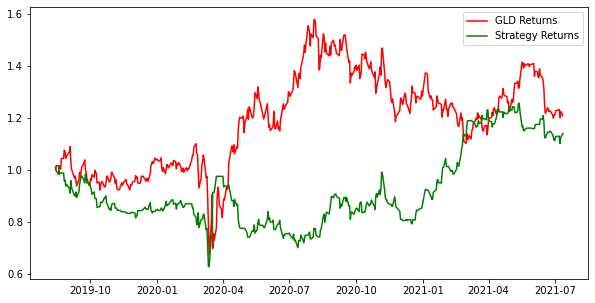

In [171]:
plt.figure(figsize=(10,5))
plt.plot(((Df['Ret'][split:]+1).cumprod()),color='r',label='GLD Returns')
plt.plot(((Df['Ret1'][split:]+1).cumprod()),color='g',label='Strategy Returns')
plt.legend()
plt.show()

In [172]:
# The below function returns the Sharpe ratio for the excess returns
def annualized_sharpe_ratio(returns, N=252):
    return np.sqrt(N) * returns.mean() / returns.std()

# Calculate the excess daily return by assuming an annual risk free rate of return of 5%
excess_daily_strategy_return = Df['Ret1'][split:] - 0.05/252

# Calculate the annualized Sharpe ratio
sharpe = annualized_sharpe_ratio(excess_daily_strategy_return)
print('Sharpe', sharpe)

Sharpe 0.23492021408208053


In [2]:
import flair as fl

ModuleNotFoundError: No module named 'flair'

In [3]:
!pip uninstall flair

Found existing installation: flair 0.8.0.post1
Uninstalling flair-0.8.0.post1:
  Would remove:
    /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/flair-0.8.0.post1.dist-info/*
    /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/flair/*
Proceed (y/n)? ^C
ERROR: Operation cancelled by user


In [4]:
import flair

ModuleNotFoundError: No module named 'flair'